In [3]:
pip install cvxopt

   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.8 MB 435.7 kB/s eta 0:00:30
   ---------------------------------------- 0.1/12.8 MB 770.8 kB/s eta 0:00:17
   ---------------------------------------- 0.1/12.8 MB 722.1 kB/s eta 0:00:18
   ---------------------------------------- 0.1/12.8 MB 722.1 kB/s eta 0:00:18
    --------------------------------------- 0.3/12.8 MB 1.1 MB/s eta 0:00:12
   - -------------------------------------- 0.4/12.8 MB 1.5 MB/s eta 0:00:09
   - -------------------------------------- 0.6/12.8 MB 1.7 MB/s eta 0:00:08
   -- ------------------------------------- 0.7/12.8 MB 1.8 MB/s eta 0:00:07
   -- ------------------------------------- 0.8/12.8 MB 1.9 MB/s eta 0:00:07
   -- ------------------------------------- 0.9/12.8 MB 2.0 MB/s eta 0:00:06
   --- ------------------------------------ 1.1/12.8 MB 2.1 MB/s eta 0:00:06
   --

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from matplotlib.colors import ListedColormap

Dataset:
    Feature 1  Feature 2  Class
0   1.392452   1.873864      1
1   1.315394   2.928715      1
2   0.155599   1.532998      1
3   4.292490   2.488810      1
4   2.710267   3.055534      1
     pcost       dcost       gap    pres   dres
 0: -1.1177e+01 -2.1673e+01  3e+02  2e+01  2e+00
 1: -1.7054e+01 -1.2874e+01  1e+02  6e+00  7e-01
 2: -5.0844e+01 -2.5693e+01  1e+02  4e+00  5e-01
 3: -2.0549e+01 -4.6241e+00  3e+01  1e+00  1e-01
 4: -9.5036e-01 -1.7459e+00  8e-01  1e-15  8e-15
 5: -1.3890e+00 -1.4350e+00  5e-02  7e-16  2e-15
 6: -1.4248e+00 -1.4253e+00  6e-04  3e-16  2e-15
 7: -1.4252e+00 -1.4252e+00  6e-06  3e-16  2e-15
 8: -1.4252e+00 -1.4252e+00  6e-08  2e-16  2e-15
Optimal solution found.


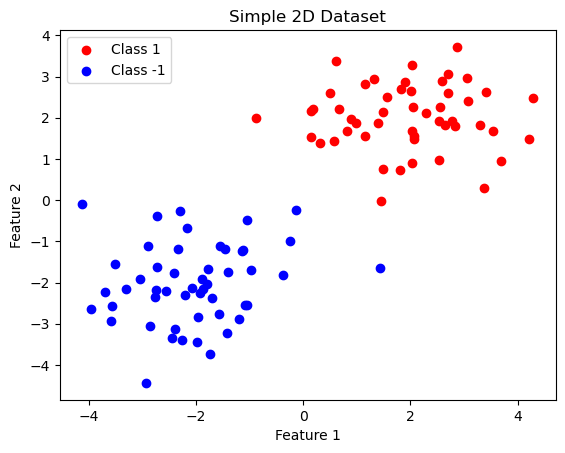

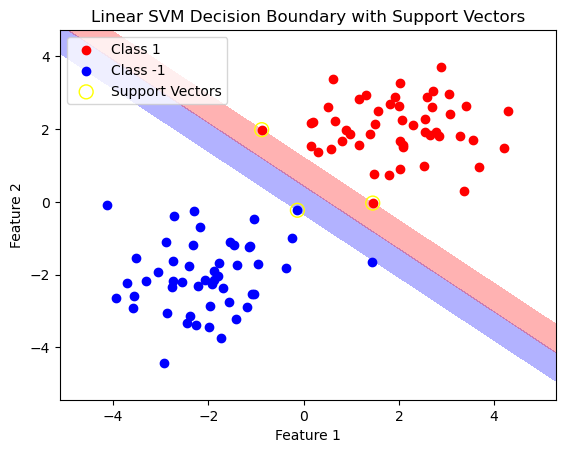

In [7]:

def generate_linearly_separable_dataset(n_samples=100, random_state=40):
    np.random.seed(random_state)
    X = np.random.randn(n_samples, 2)
    X[:n_samples//2] = X[:n_samples//2] + 2
    X[n_samples//2:] = X[n_samples//2:] - 2
    y = np.array([1] * (n_samples // 2) + [-1] * (n_samples // 2))
    return X, y

def create_dataframe(X, y):
    df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
    df['Class'] = y
    return df

def plot_dataset(X, y, title='Dataset'):
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
    plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='blue', label='Class -1')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

def plot_decision_boundary(X, y, w, b, support_vectors, title='Decision Boundary'):
    x0, x1 = np.meshgrid(
        np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
        np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    y_pred = np.dot(X_new, w) + b
    zz = y_pred.reshape(x0.shape)
    plt.contourf(x0, x1, zz, levels=[-1, 0, 1], alpha=0.3, cmap=ListedColormap(['blue', 'red']))
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
    plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='blue', label='Class -1')
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
                facecolors='none', edgecolors='yellow', label='Support Vectors')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

def svm_qp(X, y):
    n_samples, n_features = X.shape
    y = y.astype(float)
    
    # Kernel matrix
    K = np.outer(y, y) * np.dot(X, X.T)
    
    P = matrix(K)
    q = matrix(-np.ones((n_samples, 1)))
    G = matrix(np.diag(-np.ones(n_samples)))
    h = matrix(np.zeros(n_samples))
    A = matrix(y, (1, n_samples), 'd')
    b = matrix(0.0)
    
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    
    # Support vectors have non-zero Lagrange multipliers
    support_vector_indices = alphas > 1e-5
    alphas = alphas[support_vector_indices.flatten()]
    support_vectors = X[support_vector_indices.flatten()]
    support_vector_labels = y[support_vector_indices.flatten()]
    
    # Calculate w and b
    w = np.sum(alphas * support_vector_labels[:, None] * support_vectors, axis=0)
    b = np.mean(support_vector_labels - np.dot(support_vectors, w))
    
    return w, b, support_vectors

def main():
    # Generate and visualize the dataset
    X, y = generate_linearly_separable_dataset()
    
    # Create and display a DataFrame of the dataset
    df = create_dataframe(X, y)
    print("Dataset:\n", df.head())
    
    # Train a linear SVM using quadratic programming
    w, b, support_vectors = svm_qp(X, y)
    
    # Plot the original dataset
    plot_dataset(X, y, title='Simple 2D Dataset')
    
    # Plot the decision boundary along with support vectors
    plot_decision_boundary(X, y, w, b, support_vectors, title='Linear SVM Decision Boundary with Support Vectors')

if __name__ == "__main__":
    main()


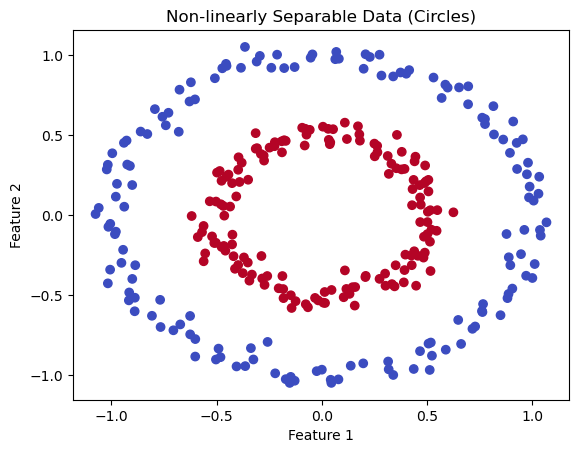

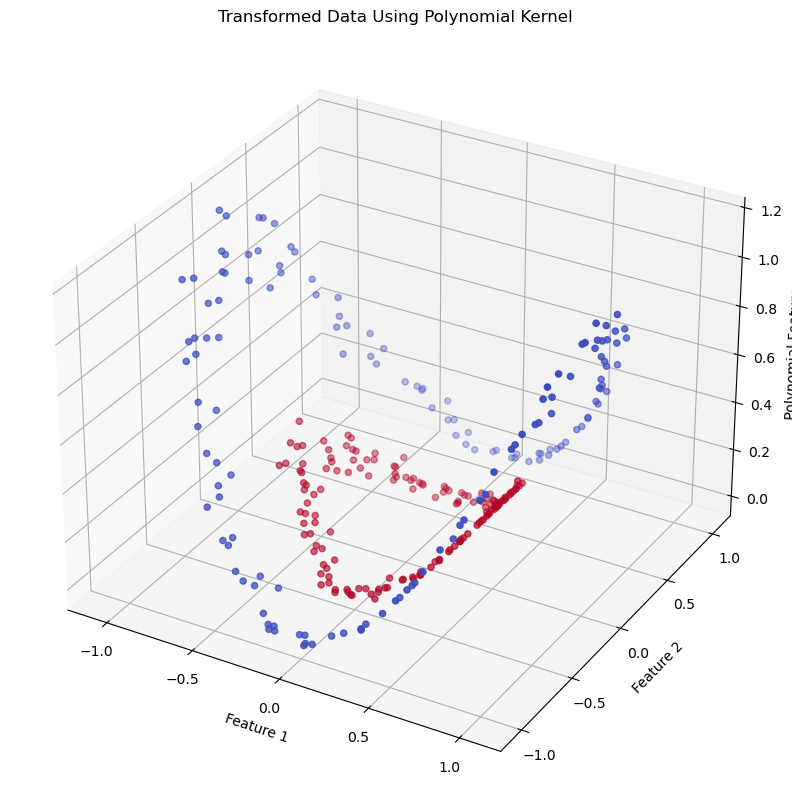

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        46

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



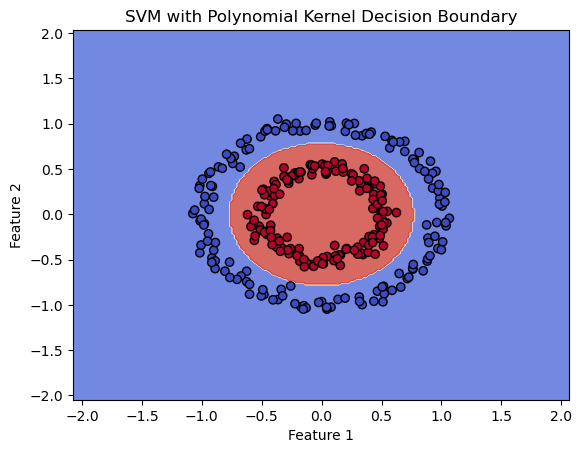

In [9]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from cvxopt import matrix, solvers
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_circles
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm
from IPython.display import display
def create_dataset():
    """
    Create a non-linearly separable dataset with interleaving circles.
    
    Returns:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target vector.
    """
    X, y = make_circles(n_samples=300, factor=.5, noise=.05)
    return X, y

def plot_original_data(X, y):
    """
    Plot the original non-linearly separable dataset.
    
    Args:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target vector.
    """
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.title('Non-linearly Separable Data (Circles)')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

def transform_data(X):
    """
    Transform the data using a polynomial feature map.
    
    Args:
        X (np.ndarray): Original feature matrix.
    
    Returns:
        X_poly (np.ndarray): Transformed feature matrix.
    """
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    return X_poly

def plot_transformed_data(X_poly, y):
    """
    Plot the transformed data in 3D.
    
    Args:
        X_poly (np.ndarray): Transformed feature matrix.
        y (np.ndarray): Target vector.
    """
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_poly[:, 1], X_poly[:, 2], X_poly[:, 3], c=y, cmap=plt.cm.coolwarm)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Polynomial Feature')
    plt.title('Transformed Data Using Polynomial Kernel')
    plt.show()

def train_svm(X_train, y_train):
    """
    Train an SVM classifier with a polynomial kernel.
    
    Args:
        X_train (np.ndarray): Training feature matrix.
        y_train (np.ndarray): Training target vector.
    
    Returns:
        clf (SVC): Trained SVM classifier.
    """
    clf = SVC(kernel='poly', degree=2, C=1.0)
    clf.fit(X_train, y_train)
    return clf

def evaluate_model(clf, X_test, y_test):
    """
    Evaluate the SVM classifier and print accuracy and classification report.
    
    Args:
        clf (SVC): Trained SVM classifier.
        X_test (np.ndarray): Test feature matrix.
        y_test (np.ndarray): Test target vector.
    """
    y_pred = clf.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

def plot_decision_boundary(clf, X, y):
    """
    Plot the decision boundary of the SVM classifier in the original 2D space.
    
    Args:
        clf (SVC): Trained SVM classifier.
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target vector.
    """
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('SVM with Polynomial Kernel Decision Boundary')
    plt.show()

def main():
    # Step 1: Create and plot the original dataset
    X, y = create_dataset()
    plot_original_data(X, y)

    # Step 2: Transform the data and plot it in 3D
    X_poly = transform_data(X)
    plot_transformed_data(X_poly, y)

    # Step 3: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Step 4: Train the SVM classifier
    clf = train_svm(X_train, y_train)

    # Step 5: Evaluate the SVM classifier
    evaluate_model(clf, X_test, y_test)

    # Step 6: Plot the decision boundary in the original 2D space
    plot_decision_boundary(clf, X, y)

if __name__ == "__main__":
    main()